In [ ]:
# =========================================
# LinkedIn Jobs Analysis - Jupyter Notebook
# =========================================
# Description: Data cleaning, exploratory analysis,
#              and visualization of LinkedIn job postings in Sweden.

# Data cleaning

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
from wordcloud import WordCloud

# Configure plots
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False

# Load cleaned dataset
df = pd.read_csv("./data/linkedin_jobs_250809_final.csv")
print(df.shape)
print(df.isna().sum())
df.head()


(1000, 8)
title                 0
company               0
location              0
posted_before         0
application_number    0
detail                0
description           0
url                   0
dtype: int64


,title,company,location,posted_before,application_number,detail,description,url
0,Servitör,Prime consulting sweden,"Malmo, Skåne County, Sweden",Reposted 2 days ago,36 applicants,"On-site\nSkills: English, teamwork, +8 more",About the job\nJobba extra inom bemanning – fl...,https://www.linkedin.com/jobs/search/?currentJ...
1,Translator - Swedish,Testronic,Sweden,1 week ago,90 applicants,Remote Contract Associate\nSkills: Translation...,"About the job\nCurrently, Testronic Translatio...",https://www.linkedin.com/jobs/search/?currentJ...
2,"Restaurangmedarbetare , Malmö",Holy Greens,"Malmo, Skåne County, Sweden",1 week ago,36 people clicked apply,On-site Full-time Entry level\nSkills: Operati...,"About the job\nHar du energi, tycker om att ta...",https://www.linkedin.com/jobs/search/?currentJ...
3,Healthcare Assistant - No Experience Needed - ...,Mercier Consultancy Bulgaria,Sweden,3 weeks ago,Over 100 applicants,€28K/yr - €30K/yr Remote Full-time Entry level...,About the job\nMercier Consultancy BG is excit...,https://www.linkedin.com/jobs/search/?currentJ...
4,Spontanansökan,Skåne Stadsmission,"Malmo, Skåne County, Sweden",1 week ago,36 people clicked apply,"On-site Contract\nSkills: AV, Operations Manag...",About the job\nSkåne Stadsmission gör varje da...,https://www.linkedin.com/jobs/search/?currentJ...


In [8]:
# Drop duplicates
df["job_id"] = df["url"].str.extract(r'currentJobId=(\d+)')
duplicate_count = df["job_id"].duplicated().sum()
duplicates = df[df["job_id"].duplicated(keep=False)].sort_values("job_id")

print(f"number of duplicated data: {duplicate_count}")
print(duplicates[["job_id", "title", "company", "url"]])



number of duplicated data: 0
Empty DataFrame
Columns: [job_id, title, company, url]
Index: []


In [11]:
df = df.drop_duplicates(subset='job_id', keep='first')

# Handle missing values
df.isna().sum()

# Convert applications to numeric
df["applications"] = pd.to_numeric(df["application_number"], errors="coerce")

# Extract days posted (simple parsing from 'posted_before')
df["days_posted"] = df["posted_before"].str.extract(r"(\d+)").astype(float)
df["days_posted"] = df["days_posted"].fillna(0)
print(df.shape)

(618, 11)


In [12]:
# Extract job_id
df["job_id"] = df["url"].str.extract(r'currentJobId=(\d+)')

# Extract the city (the first part of the location)
df['city'] = df['location'].str.split(',').str[0].str.strip()

# Extract work_mode
df["work_mode"] = df["detail"].str.extract(r'(Remote|On-site|Hybrid)', expand=False)

# Extract application
df["applications"] = df["application_number"].str.extract(r'(\d+)').astype(float)

# Extract Skills（Original string）
df["skills"] = df["detail"].str.extract(r'Skills:\s*(.*)', expand=False)

In [13]:
# Organize the new table
df_cleaned = df[[
    "job_id", "title", "company", "city", "location",
    "work_mode", "applications", "posted_before", "skills", "url"
]].drop_duplicates(subset="job_id")

# Save to a new cleaned CSV
output_path = "./data/linkedin_jobs_cleaned.csv"
df_cleaned.to_csv(output_path, index=False)

print("cleaned data saved to:", output_path)

cleaned data saved to: ./data/linkedin_jobs_cleaned.csv


 # Exploratory analysis

In [14]:
# Top 10 Cities
city_counts = df['city'].value_counts()
print(city_counts.head(10))
# Top 10 Companies
company_counts = df['company'].value_counts()
print(company_counts.head(10))

city
Stockholm         128
Gothenburg         64
Malmo              45
European Union     25
Uppsala            19
EMEA               19
Solna              14
Helsingborg        12
Sweden             11
Lund               11
Name: count, dtype: int64
company
Internetmedicin                                 21
Allakando                                       13
MAX Burgers                                     11
Vattenfall                                       9
Pinchos                                          9
ESS Group                                        8
Pincho Nation                                    8
2007 NANNYNU AB                                  8
Dals                                             7
Internationella Engelska Skolan i Sverige AB     7
Name: count, dtype: int64


In [15]:
# Statistics by work_mode
df['work_mode'] = df['detail'].str.extract(r'(Remote|On-site|Hybrid)', expand=False)
print(df['work_mode'].value_counts())

work_mode
On-site    390
Remote      91
Hybrid      43
Name: count, dtype: int64


In [16]:
# The position with the most applicants
print(df['applications'].describe())
hot_jobs = df.sort_values('applications', ascending=False).head(10)
print(hot_jobs[['title', 'company', 'applications']])

count    618.000000
mean      34.587379
std       39.964404
min        0.000000
25%        2.000000
50%       12.000000
75%       77.000000
max      100.000000
Name: applications, dtype: float64
                                                 title  \
16         Är du redo att ta nästa steg i din karriär?   
9                                          Recepionist   
22                                     Legal Associate   
19                                LIA/Praktik på Tele2   
18                         Food And Beverage Assistant   
3    Healthcare Assistant - No Experience Needed - ...   
34                                            Inköpare   
28                                Online Spanish Tutor   
42                     Remote Data Annotator - Swedish   
373                         Technical Support Engineer   

                          company  applications  
16                          Sweco         100.0  
9                             JLL         100.0  
22              

In [17]:
# Extract each skill from the skill field
skills_series = df['detail'].str.extract(r'Skills:\s*(.*)')[0].dropna()

# Split and count
skills_list = [skill.strip() for skills in skills_series for skill in skills.split(',')]
skill_counts = Counter(skills_list)
print(skill_counts.most_common(20))

[('+8 more', 438), ('AV', 105), ('Operations Management', 82), ('Analytical Skills', 50), ('English', 41), ('+2 more', 32), ('Swedish', 28), ('Food and Beverage', 27), ('open source software', 24), ('+4 more', 22), ('+1 more', 21), ('Open Source Software', 20), ('+3 more', 18), ('+5 more', 17), ('Housekeeping', 15), ('+7 more', 15), ('Teaching', 13), ('Bartending', 13), ('Team Leadership', 11), ('Food & Beverage', 10)]


In [18]:
# Simple processing posted_before
time_counts = df['posted_before'].value_counts()
print(time_counts)

posted_before
1 week ago               133
2 weeks ago               88
3 weeks ago               75
2 days ago                47
4 days ago                46
1 day ago                 34
3 days ago                28
Reposted 1 week ago       26
5 days ago                26
4 weeks ago               22
Reposted 2 weeks ago      18
1 month ago               12
Reposted 3 weeks ago       8
Reposted 2 days ago        6
Reposted 6 days ago        6
Reposted 1 day ago         6
Reposted 3 days ago        5
15 hours ago               4
Reposted 4 days ago        3
14 hours ago               3
Reposted 20 hours ago      3
Reposted 19 hours ago      2
Reposted 15 hours ago      2
20 hours ago               2
22 hours ago               2
Reposted 5 days ago        2
12 hours ago               1
11 hours ago               1
21 hours ago               1
6 days ago                 1
6 hours ago                1
17 hours ago               1
Reposted 18 hours ago      1
Reposted 17 hours ago      1


In [19]:
avg_applications = df['applications'].mean()
competitive_jobs = df[df['applications'] > avg_applications]
print(competitive_jobs[['title', 'company', 'applications']].head())

                                               title  \
0                                           Servitör   
1                               Translator - Swedish   
2                      Restaurangmedarbetare , Malmö   
3  Healthcare Assistant - No Experience Needed - ...   
4                                     Spontanansökan   

                        company  applications  
0       Prime consulting sweden          36.0  
1                     Testronic          90.0  
2                   Holy Greens          36.0  
3  Mercier Consultancy Bulgaria         100.0  
4            Skåne Stadsmission          36.0  


In [26]:
# Convert posted_before to days
def convert_to_days(text):
    if pd.isna(text):
        return None
    text = text.lower()
    if "day" in text:
        num = int(re.search(r"\d+", text).group()) if re.search(r"\d+", text) else 1
        return num
    elif "week" in text:
        num = int(re.search(r"\d+", text).group()) if re.search(r"\d+", text) else 1
        return num * 7
    elif "month" in text:
        num = int(re.search(r"\d+", text).group()) if re.search(r"\d+", text) else 1
        return num * 30
    elif "hour" in text:
        return 0  # positions posted just now
    else:
        return None

df_cleaned["days_posted"] = df_cleaned["posted_before"].apply(convert_to_days)

# Calculate Competitiveness( = Applications per day )
df_cleaned["competitiveness"] = df_cleaned["applications"] / (df_cleaned["days_posted"] + 1)

# Top 10 most competitive jobs
top_competitive_jobs = df_cleaned.sort_values("competitiveness", ascending=False).head(10)
# Median competitiveness
median_comp = df_cleaned["competitiveness"].median()
# Top 10 least competitive jobs
bottom_competitive_jobs = df_cleaned.sort_values("competitiveness", ascending=True).head(10)

median_comp, bottom_competitive_jobs[["title", "company", "applications", "days_posted", "competitiveness"]]

(np.float64(1.2),
                                                  title  \
 992                                  Frisör till Malmö   
 986            Extrapersonal sökes till Stigen av Knut   
 984   Bli digital Mattecoach - hjälp andra med matten!   
 46   Communications & Marketing Officer (tidsbegrän...   
 972                                      Elevassistent   
 922                                            Barchef   
 923                  Bartender till Pinchos Skellefteå   
 82                 MAX Sisjön söker nya kollegor 20h/v   
 796                Förskollärare till Kortedala Park 1   
 812  Butiksmedarbetare (extrajobb), Willys Jönköpin...   
 
                                company  applications  days_posted  \
 992                       Carl M Lundh           0.0            2   
 986           KNUT RESTAURANG & BAR AB           0.0            4   
 984  Chalmers University of Technology           0.0            3   
 46                      Paragon Nordic           0

In [20]:
# Split and clean skills
skills_series = df_cleaned["skills"].dropna().apply(lambda x: [s.strip() for s in x.split(",")])
all_skills = [skill for skills in skills_series for skill in skills]
all_skills = [s for s in all_skills if not re.match(r"\+\d+\s*more", s, re.IGNORECASE)]

# Top 20 most frequent skills
skill_counts = Counter(all_skills).most_common(20)

# Convert to DataFrame for visualization
skills_df = pd.DataFrame(skill_counts, columns=["Skill", "Count"])
print(skills_df.head(10))

                   Skill  Count
0                     AV    105
1  Operations Management     82
2      Analytical Skills     50
3                English     41
4                Swedish     28
5      Food and Beverage     27
6   open source software     24
7   Open Source Software     20
8           Housekeeping     15
9               Teaching     13


# Visualization

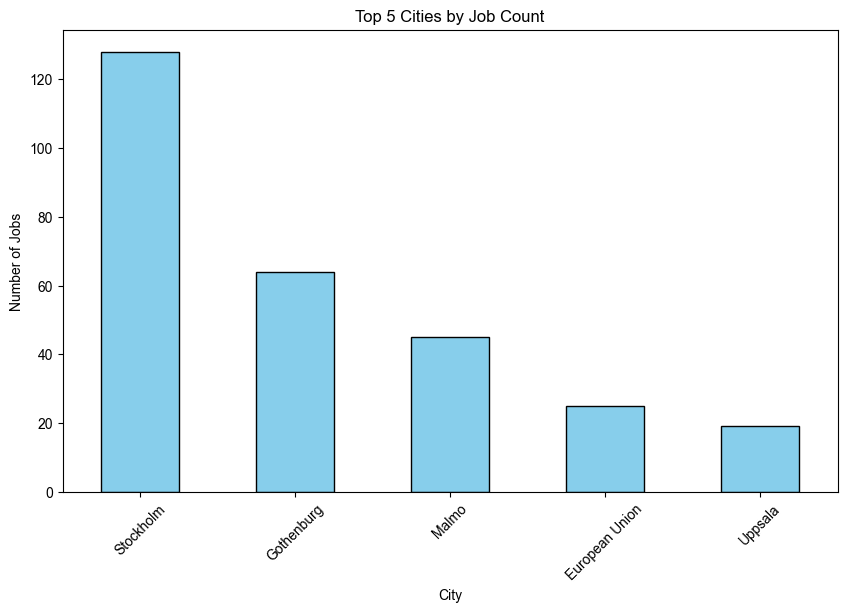

In [5]:
# 1. Top 10 Cities by Job Count
df_cleaned = pd.read_csv("./data/linkedin_jobs_cleaned.csv")
city_counts = df_cleaned["city"].value_counts().head(5)

plt.figure(figsize=(10,6))
city_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Top 5 Cities by Job Count")
plt.xlabel("City")
plt.ylabel("Number of Jobs")
plt.xticks(rotation=45)
plt.savefig("./visualization/top5_cities.png", dpi=300, bbox_inches="tight")
plt.show()

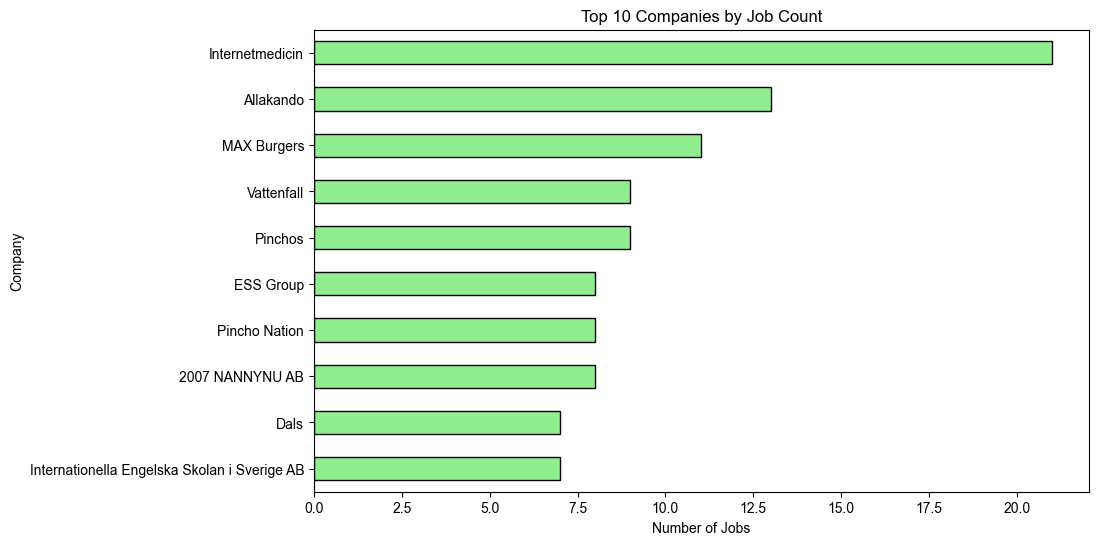

In [6]:
# 2. Top 10 Companies by Job Count

company_counts = df_cleaned["company"].value_counts().head(10)

plt.figure(figsize=(10,6))
company_counts.plot(kind="barh", color="lightgreen", edgecolor="black")
plt.title("Top 10 Companies by Job Count")
plt.xlabel("Number of Jobs")
plt.ylabel("Company")
plt.gca().invert_yaxis()
plt.savefig("./visualization/top10_companies.png", dpi=300, bbox_inches="tight")
plt.show()

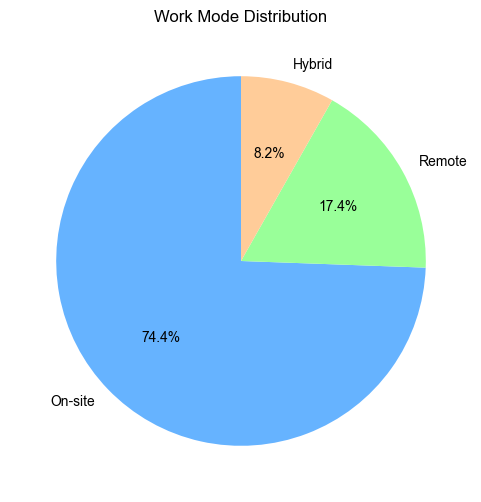

In [7]:
# 3. Work Mode Distribution

work_mode_counts = df_cleaned["work_mode"].value_counts()

plt.figure(figsize=(6,6))
work_mode_counts.plot(kind="pie", autopct="%1.1f%%", startangle=90,
                      colors=["#66b3ff","#99ff99","#ffcc99"])
plt.title("Work Mode Distribution")
plt.ylabel("")
plt.savefig("./visualization/work_mode_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

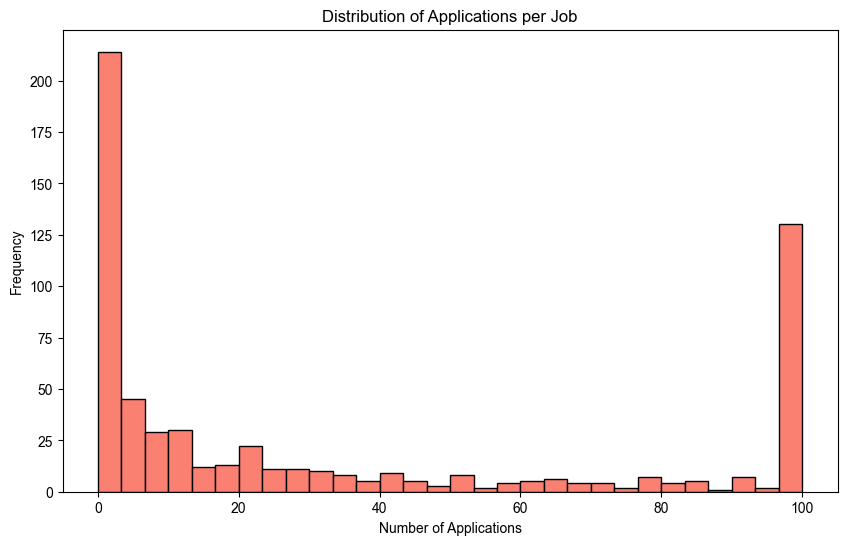

In [8]:
# 4. Distribution of Applications per Job

plt.figure(figsize=(10,6))
df_cleaned["applications"].dropna().plot(kind="hist", bins=30,
                                         color="salmon", edgecolor="black")
plt.title("Distribution of Applications per Job")
plt.xlabel("Number of Applications")
plt.ylabel("Frequency")
plt.savefig("./visualization/applications_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

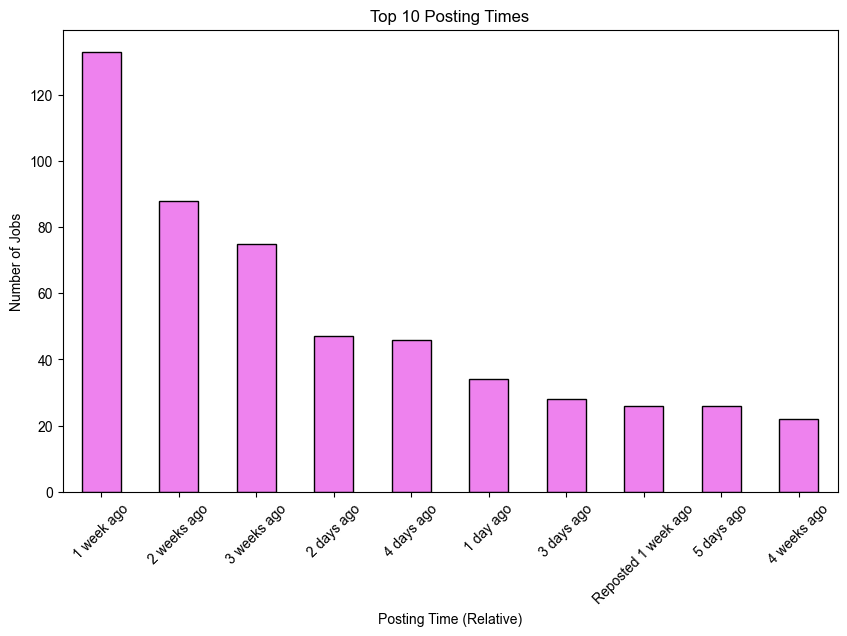

In [9]:
# 5. Top 10 Posting Times

time_counts = df_cleaned["posted_before"].value_counts().head(10)

plt.figure(figsize=(10,6))
time_counts.plot(kind="bar", color="violet", edgecolor="black")
plt.title("Top 10 Posting Times")
plt.xlabel("Posting Time (Relative)")
plt.ylabel("Number of Jobs")
plt.xticks(rotation=45)
plt.savefig("./visualization/posting_times.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
# 5. Competitiveness（Top 10）

plt.figure(figsize=(10,6))
df_cleaned["competitiveness"].plot(kind="hist", bins=30, color="teal", edgecolor="black")
plt.axvline(median_comp, color="red", linestyle="--", label=f"Median = {median_comp:.2f}")
plt.title("Distribution of Job Competitiveness")
plt.xlabel("Applications per Day (Competitiveness)")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("./visualization/competitiveness.png", dpi=300, bbox_inches="tight")
plt.show()

KeyError: 'competitiveness'

<Figure size 1000x600 with 0 Axes>

In [11]:
# 5. Most required skills（Top 20） in barh

plt.figure(figsize=(10,6))
plt.barh(skills_df["Skill"], skills_df["Count"], color="steelblue", edgecolor="black")
plt.gca().invert_yaxis()  # 让最多的在最上面
plt.title("Top 20 Most Demanded Skills in Sweden (LinkedIn Data)")
plt.xlabel("Number of Occurrences")
plt.ylabel("Skill")
plt.tight_layout()
plt.savefig("./visualization/top20_skills.png", dpi=300, bbox_inches="tight")
plt.show()

NameError: name 'skills_df' is not defined

<Figure size 1000x600 with 0 Axes>

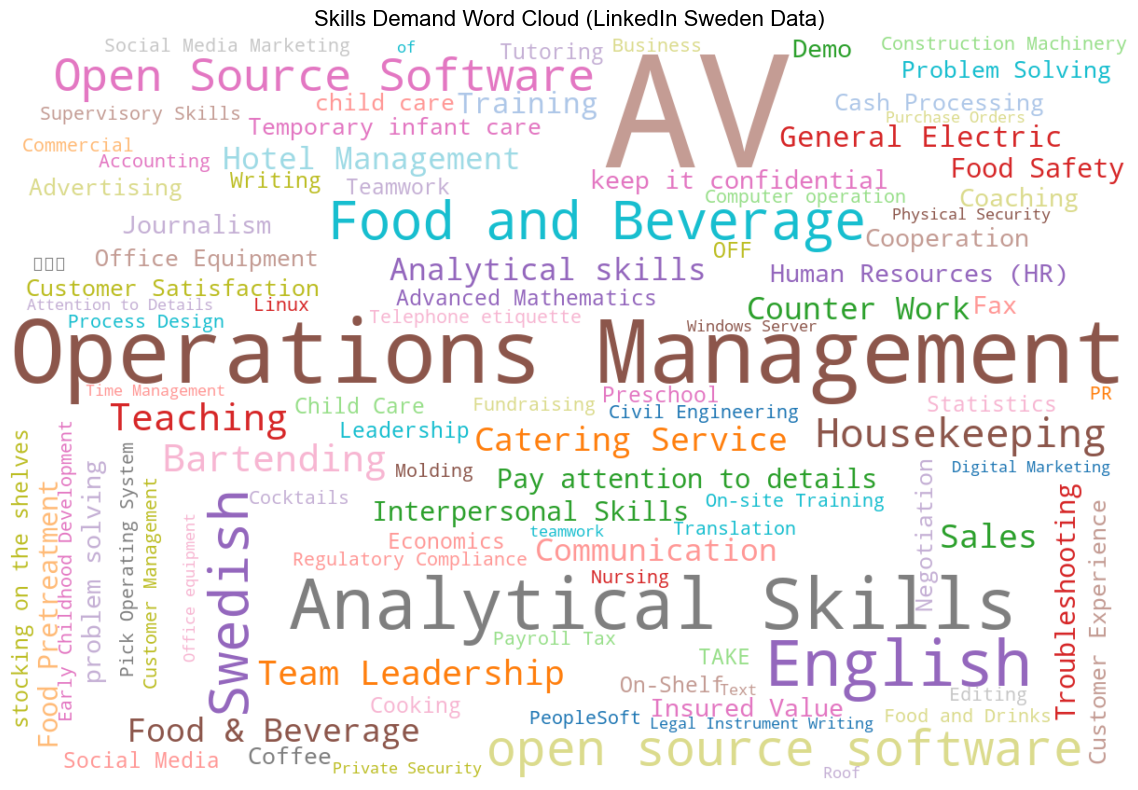

In [29]:
# 5. Most required skills（Top 20） in wordcloud
skill_counts = Counter(all_skills)

wc = WordCloud(
    width=1200, height=800,
    background_color="white",
    colormap="tab20",
    max_words=100
).generate_from_frequencies(skill_counts)

plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Skills Demand Word Cloud (LinkedIn Sweden Data)", fontsize=16)
plt.tight_layout()
plt.savefig("./visualization/skills_wordcloud.png", dpi=300, bbox_inches="tight")
plt.show()